Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

Getting the data

In [6]:
df=pd.read_excel('Online Retail.xlsx')

#Data Exploration

In [7]:
df.shape

(541909, 8)

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [10]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [11]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The above cell shows that 'Quantity' and 'UnitPrice' columns have negative values. 

The negative values can be because of cancellation or return of orders, these must be removed as they would affect the dataset.

In [12]:
def descr(df):
  no_rows=df.shape[0]
  types=df.dtypes
  counts=df.apply(lambda x: x.count())
  uniques=df.apply(lambda x: x.unique())
  nulls=df.apply(lambda x: x.isnull().sum())
  distincts=df.apply(lambda x: x.unique().shape[0])
  nan_percent=(df.isnull().sum()/no_rows)*100
  skewness=df.skew()
  kurtosis=df.kurt()

  cols={'dtypes':types, 'counts':counts, 'distincts':distincts, 'nulls':nulls,  
        'missing_percent':nan_percent, 'uniques':uniques, 'skewness':skewness, 'kurtosis':kurtosis}
  table=pd.DataFrame(data=cols)
  return table

details = descr(df)
display(details.sort_values(by='missing_percent', ascending=False))

,dtypes,counts,distincts,nulls,missing_percent,uniques,skewness,kurtosis
CustomerID,float64,406829,4373,135080,24.926694,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.029835,-1.179982
Description,object,540455,4224,1454,0.268311,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
Country,object,541909,38,0,0.000000,"[United Kingdom, France, Australia, Netherland...",NaN,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN
Quantity,int64,541909,722,0,0.000000,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",-0.264076,119769.160031
StockCode,object,541909,4070,0,0.000000,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",186.506972,59005.719097


From here we can see that 'CustomerID' and 'Description' columns have NaN values.

#Data Cleaning

Finding out where all the negative and values are present

In [13]:
print("Number of rows where negative values are present : ", 
      df[(df['Quantity']<0) | (df['UnitPrice']<0)].shape[0])

print("\nAre negative values in both Quantity and UnitPrice present in same row : ", end="")
if df[(df['Quantity']<0) & (df['UnitPrice']<0)].shape[0]==0:
  print("No")
else:
  print("Yes")

print("\nAre negative or 0 values in both Quantity and UnitPrice present in same row : ", end="")
if df[(df['Quantity']<=0) & (df['UnitPrice']<=0)].shape[0]==0:
  print("No")
else:
  print("Yes")

print("What is the customer ID of such rows :",
      df.loc[(df.Quantity<=0) & (df.UnitPrice<=0), ['CustomerID']].CustomerID.unique())

Number of rows where negative values are present :  10626

Are negative values in both Quantity and UnitPrice present in same row : No

Are negative or 0 values in both Quantity and UnitPrice present in same row : Yes
What is the customer ID of such rows : [nan]


In [14]:
print("Invoice Numbers of rows with quantity having negative values : ") 
print(df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'])
print("\nAll the Invoice Numbers start with : ", df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Invoice Numbers of rows with quantity having negative values : 
141       C536379
154       C536383
235       C536391
236       C536391
237       C536391
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 8905, dtype: object

All the Invoice Numbers start with :  ['C']


In [15]:
print("Invoice Numbers of rows with UnitPrice having negative values : ") 
display(df[(df.UnitPrice<0) & (df.CustomerID.isnull())])
print("\nAll the Invoice Numbers start with : ", df.loc[(df.UnitPrice<0) & (df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

print("\nInvoice Numbers of rows with UnitPrice having 0 values : ") 
display(df[(df.UnitPrice==0) & ~(df.CustomerID.isnull())].head(10))
print("Total number of rows : ", df[(df.UnitPrice==0) & ~(df.CustomerID.isnull())].shape[0])
#print("\nAll the Invoice Numbers start with : ", df.loc[(df.UnitPrice==0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

Invoice Numbers of rows with UnitPrice having negative values : 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom



All the Invoice Numbers start with :  ['A']

Invoice Numbers of rows with UnitPrice having 0 values : 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


Total number of rows :  40



Dropping the rows having negative and null values based on what we found above

In [16]:
df=df[~(df.CustomerID.isnull())]
df = df[~(df.Quantity<0)]
df = df[df.UnitPrice>0]
df.reset_index()
details = descr(df)
display(details.sort_values(by='distincts', ascending=False))
print(df.shape)

,dtypes,counts,distincts,nulls,missing_percent,uniques,skewness,kurtosis
InvoiceNo,object,397884,18532,0,0.0,"[536365, 536366, 536367, 536368, 536369, 53637...",-0.178524,-1.200748
InvoiceDate,datetime64[ns],397884,17282,0,0.0,"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",NaN,NaN
CustomerID,float64,397884,4338,0,0.0,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.025729,-1.180822
Description,object,397884,3877,0,0.0,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
StockCode,object,397884,3665,0,0.0,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
UnitPrice,float64,397884,440,0,0.0,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",409.892972,178186.243253
Country,object,397884,37,0,0.0,"[United Kingdom, France, Australia, Netherland...",NaN,NaN


(397884, 8)


Here, we have removed all null and negative values from dataset

In [17]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [29]:
dfv=df.copy()                               #making a copy of DataFrame 


Assigning numerical values to all the elements in StockCode

In [30]:
x=dfv['StockCode'].value_counts()
item_type_mapping={}
item_list=x.index
for i in range(0,len(item_list)):
    item_type_mapping[item_list[i]]=i

dfv['StockCode']=dfv['StockCode'].map(lambda x:item_type_mapping[x]) 

Adding 'amount column which shows total amount spent by the customer

In [31]:
dfv['amount'] = dfv.Quantity*dfv.UnitPrice
dfv['amount']

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: amount, Length: 397884, dtype: float64

#Data Visualisation

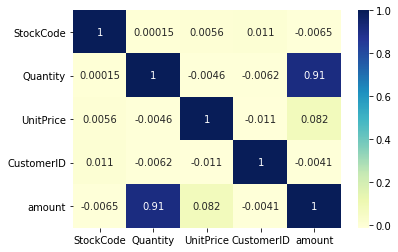

In [32]:
sns.heatmap(dfv.corr(), cmap="YlGnBu", annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f235c844e50>,
      dtype=object)

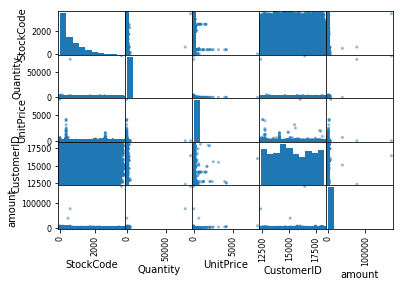

In [33]:
pd.plotting.scatter_matrix(dfv)

In [34]:
dfv = dfv[~(dfv.Quantity>dfv.Quantity.quantile(0.95))]
dfv = dfv[~(dfv.UnitPrice>dfv.UnitPrice.quantile(0.95))]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2358616ed0>,
      dtype=object)

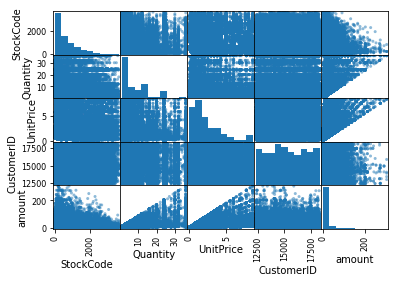

In [27]:
pd.plotting.scatter_matrix(dfv)

In [28]:
dfv.describe()

,StockCode,Quantity,UnitPrice,CustomerID,amount
count,361147.000000,361147.000000,361147.000000,361147.000000,361147.000000
mean,657.231078,7.689010,2.462422,15317.936577,13.781492
std,667.812967,7.491245,1.974761,1709.619269,15.557298
min,0.000000,1.000000,0.001000,12347.000000,0.001000
25%,135.000000,2.000000,1.250000,13988.000000,4.160000
50%,429.000000,5.000000,1.690000,15220.000000,10.200000
75%,978.000000,12.000000,2.950000,16814.000000,17.400000
max,3664.000000,36.000000,8.500000,18287.000000,306.000000


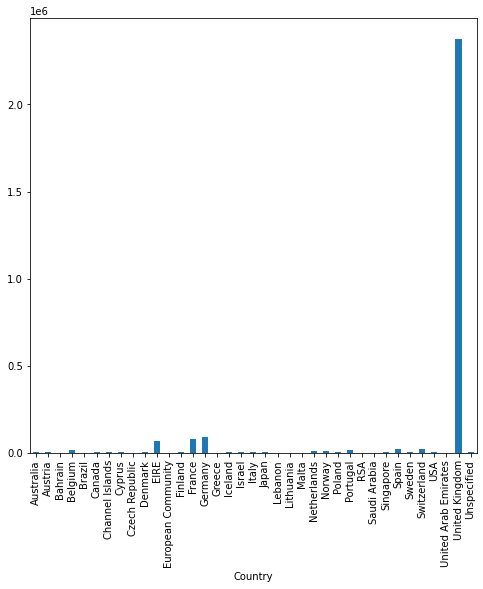

In [35]:
dfv.groupby('Country')['Quantity'].sum().plot(kind = 'bar', figsize=(8,8))

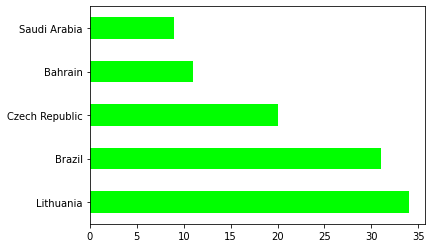

In [36]:
dfv.Country.value_counts()[-5:].plot(kind='barh',colormap='brg_r')

These are the countries with least sales

In [37]:
dfv['year'] = dfv['InvoiceDate'].dt.year
dfv['month'] = dfv['InvoiceDate'].dt.month
dfv['hour'] = dfv['InvoiceDate'].dt.hour
dfv['weekday'] = dfv['InvoiceDate'].dt.day_name()

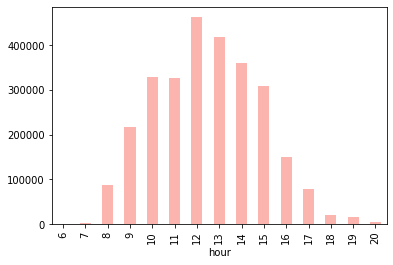

In [38]:
dfv.groupby('hour')['Quantity'].sum().plot(kind = 'bar', colormap = 'Pastel1')

This plot shows that afternoons are the busiest times

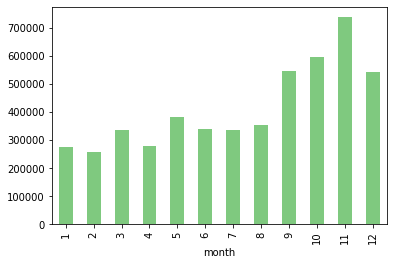

In [39]:
dfv.groupby('month')['amount'].sum().plot(kind='bar', colormap = 'Accent')

This shows that maximum sales have taken place in the last months

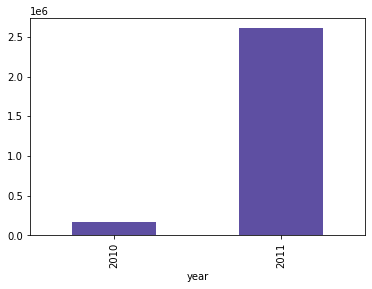

In [40]:
dfv.groupby('year')['Quantity'].sum().plot(kind='bar',colormap = 'Spectral_r')

In [41]:
dfv.InvoiceDate.sort_values()

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541896   2011-12-09 12:50:00
541895   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541900   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 361147, dtype: datetime64[ns]

The huge difference between the years is because the dataset starts from december of 2010 and ends in december 2011

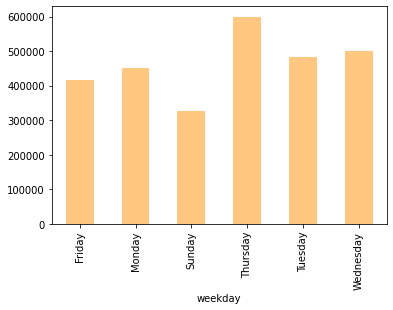

In [42]:
dfv.groupby('weekday')['Quantity'].sum().plot(kind='bar',colormap = 'copper_r')

Here we can see that no sales happen on Saturday, so the shop must be closed that day and the busiest day is Thursday

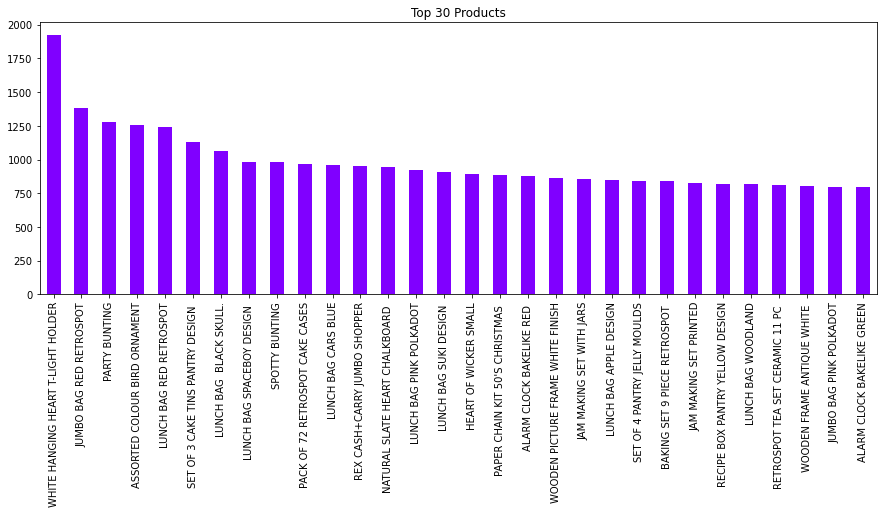

In [43]:
dfv.Description.value_counts().sort_values(ascending=False)[:30].plot(kind='bar', colormap='rainbow', figsize=(15,5), title="Top 30 Products")

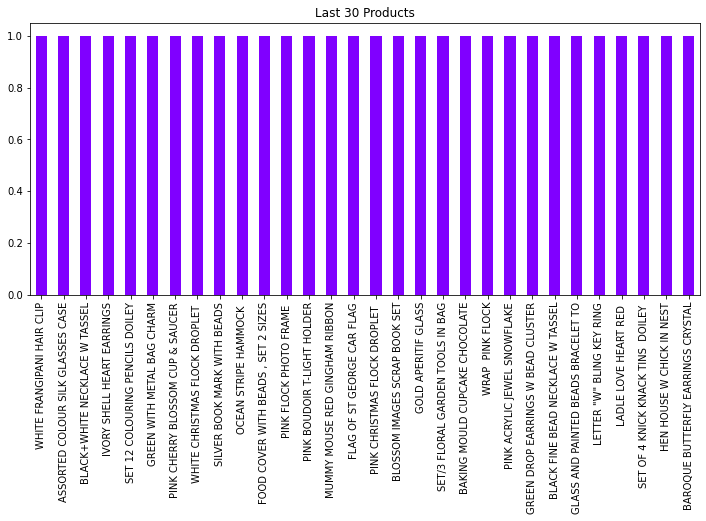

In [44]:
dfv.Description.value_counts().sort_values(ascending=False)[-30:].plot(kind='bar', colormap='rainbow', figsize=(12,5), title="Last 30 Products")

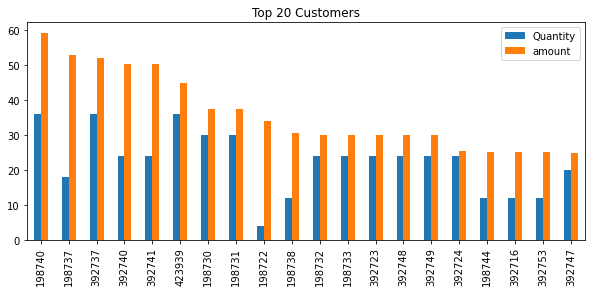

In [45]:
dfv.sort_values(['CustomerID','amount'], ascending=False).drop(['InvoiceDate','InvoiceNo','StockCode','CustomerID','year','month','hour', 'UnitPrice'], axis=1)[:20].plot(kind='bar', figsize=(10,4), title='Top 20 Customers')

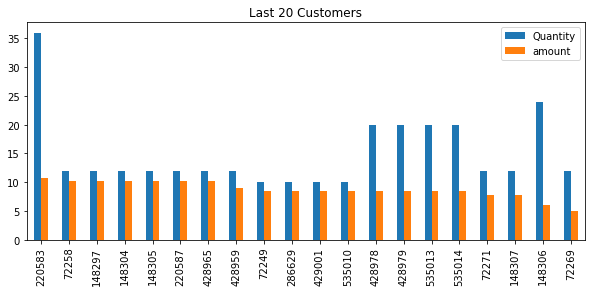

In [46]:
dfv.sort_values(['CustomerID','amount'], ascending=False).drop(['InvoiceDate','InvoiceNo','StockCode','CustomerID','year','month','hour', 'UnitPrice'], axis=1)[-20:].plot(kind='bar', figsize=(10,4), title='Last 20 Customers')